In [2]:
import numpy as np
import pyaudio
import time
import math
from random import randrange
import librosa as rosa
import librosa.display as rsdsp
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Convolution2D, Flatten, TimeDistributed, MaxPooling2D, BatchNormalization

In [60]:

num_tones = 6

f = 440
srate = 11025
frame_count = 44100
clips = 3000
output = np.zeros((clips, frame_count))
Y = np.zeros((clips, num_tones*2))

for c in range(0, clips):
    #amplitudes = np.random.uniform(0, 1/num_tones, num_tones)
    amplitudes = np.repeat([1/num_tones], num_tones)
    
    ratios = np.random.uniform(1, randrange(2, 12), num_tones)
    ratios[0] = 1
    ratios = np.sort(ratios)
    
    rates = np.random.uniform(0.9995, 0.99999, num_tones)
    rates = -np.sort(-rates)
    t = 0
    Y[c] = np.concatenate((ratios, rates))
    
    for i in range(0, frame_count):
        for ot in range(0, num_tones):
            output[c, i] += amplitudes[ot]*math.sin(math.pi * t * f * ratios[ot] / srate)
        amplitudes = amplitudes * rates
        t = t + 1
#output = output * 1000
#output = output.astype('int16')


In [80]:
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16,
                channels=1,
                rate=srate,
                output=True)

#stream.start_stream()
stream.write((output[50]*1000).astype('int16'))
print(Y[1])
stream.stop_stream()
stream.close()
p.terminate()

[1.         1.2845767  2.35165924 5.50202628 7.26005955 9.23278085
 0.99981121 0.99976923 0.99976326 0.9996211  0.99961421 0.99960086]


In [64]:
MFCC = np.zeros((clips, 64, 87))
for i in range(clips):
    MFCC[i] = rosa.feature.melspectrogram(output[i], sr=11025, n_mels=64)
    #MFCC[i] = rosa.feature.mfcc(output[i], sr=11025, n_mfcc=40)

In [189]:
CmprMFCC = np.mean(MFCC, axis=2)

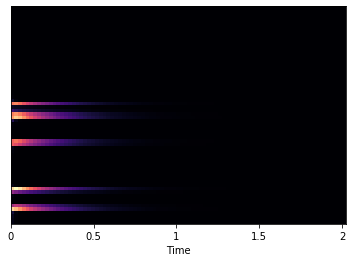

(10000, 64)


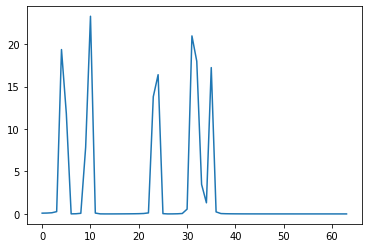

In [190]:
rsdsp.specshow(MFCC[1], x_axis='time')
plt.show()
plt.plot(CmprMFCC[1])
print(CmprMFCC.shape)

In [65]:
"""CNN network"""
#MFCC_EXP = np.expand_dims(CmprMFCC, axis=2)
MFCC_EXP = np.expand_dims(MFCC, axis=3)
cnn_model = Sequential()
cnn_model.add(BatchNormalization())
cnn_model.add(Convolution2D(32, padding="same", activation='relu', kernel_size=(8, 8), strides=(1, 1), input_shape=(128, 87, 1)))
cnn_model.add(MaxPooling2D(pool_size=(1, 1)))
cnn_model.add(Convolution2D(32, padding="same", activation='relu', kernel_size=(6, 6), strides=(1, 1)))
cnn_model.add(MaxPooling2D(pool_size=(1, 1)))
cnn_model.add(Convolution2D(32, padding="same", activation='relu', kernel_size=(4, 4), strides=(1, 1)))
cnn_model.add(MaxPooling2D(pool_size=(2, 2)))
cnn_model.add(Convolution2D(32, padding="same", activation='relu', kernel_size=(4, 4), strides=(1, 1)))
cnn_model.add(MaxPooling2D(pool_size=(4, 4)))
cnn_model.add(Convolution2D(32, padding="same", activation='relu', kernel_size=(4, 4), strides=(1, 1)))
cnn_model.add(Convolution2D(32, padding="same", activation='relu', kernel_size=(2, 2), strides=(1, 1)))
cnn_model.add(Flatten())
cnn_model.add(Dense(units=128, activation='relu'))
cnn_model.add(Dense(units=12))
cnn_model.compile(loss='mean_squared_error',
              optimizer='adam',
              metrics=['accuracy'])


In [66]:
cnn_model.fit(MFCC_EXP, Y, epochs=10)

Epoch 1/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 1.4816 - acc: 0.9180
Epoch 2/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 0.2272 - acc: 0.9753
Epoch 3/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 0.2009 - acc: 0.9717
Epoch 4/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 0.0994 - acc: 0.9680
Epoch 5/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 0.0908 - acc: 0.9510
Epoch 6/10
3000/3000 [==============================] - 53s 18ms/sample - loss: 0.0936 - acc: 0.9607
Epoch 7/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 0.0621 - acc: 0.9483
Epoch 8/10
3000/3000 [==============================] - 54s 18ms/sample - loss: 0.0524 - acc: 0.9553
Epoch 9/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 0.0505 - acc: 0.9400
Epoch 10/10
3000/3000 [==============================] - 52s 17ms/sample - loss: 0.0544 - a

In [67]:
"""LSTM network"""

lstm_model = Sequential()
lstm_model.add(LSTM(128))
lstm_model.add(Dense(units=256, activation='sigmoid'))
lstm_model.add(Dense(units=12))
lstm_model.compile(loss='mean_squared_error',
              optimizer='sgd',
              metrics=['accuracy'])
lstm_model.fit(MFCC, Y, epochs=5)

Epoch 1/5
3000/3000 [==============================] - 4s 1ms/sample - loss: 2.0141 - acc: 0.9573
Epoch 2/5
3000/3000 [==============================] - 4s 1ms/sample - loss: 1.5403 - acc: 1.0000
Epoch 3/5
3000/3000 [==============================] - 4s 1ms/sample - loss: 1.5402 - acc: 1.0000
Epoch 4/5
3000/3000 [==============================] - 4s 1ms/sample - loss: 1.5379 - acc: 1.0000
Epoch 5/5
3000/3000 [==============================] - 4s 1ms/sample - loss: 1.5374 - acc: 1.0000


In [68]:
cnn_o = cnn_model.predict(MFCC_EXP)
lstm_o = lstm_model.predict(MFCC)
print(cnn_o[41])
print(lstm_o[41])
print(Y[41])

[0.9222497  1.3867108  1.7901326  2.220046   3.2274184  4.8750696
 0.9424491  0.98494446 0.92385185 0.9547227  1.0090489  0.9465811 ]
[1.0001673  1.9776639  2.9089115  3.8677425  4.704889   5.555651
 0.99995565 1.0013021  0.99949497 0.9998628  0.99958336 0.9990152 ]
[1.         1.07458654 2.24153151 2.32781355 3.37804371 4.96750507
 0.99996445 0.99987288 0.99987216 0.999697   0.99963172 0.99950516]


In [51]:
g = 10
print(lstm_o[g])
print(Y[g])

[0.9990496 1.9408184 2.8537488 3.7443464 4.598113  5.52269   0.999747
 1.0001667 1.0002912 0.9992079 1.0004032 0.9991425]
[1.         1.00049439 3.15232853 7.22713684 7.58449371 8.17264358
 0.99986904 0.99985635 0.99977507 0.99977502 0.99972072 0.99965161]


In [69]:
cnn_diff_sum = 0
lstm_diff_sum = 0
for i in range(100):
    for j in range(6):
        cnn_diff_sum += cnn_o[i, j] - Y[i, j]
        lstm_diff_sum += lstm_o[i, j] - Y[i, j]

print(cnn_diff_sum / 600, "...", lstm_diff_sum / 600)

-0.18406817924589866 ... 0.06809481201955712


In [78]:
recreation = np.zeros((frame_count))
t = 0
smp = 50
ratios = lstm_o[smp, 0:6]
ratios[0] = 1
amplitudes = np.repeat([1/num_tones], num_tones)
rates = lstm_o[smp, 6:12]
print(ratios, " ... ", rates)
for i in range(6):
    if rates[i] > 1:
        rates[i] = 0.9999
for i in range(0, frame_count):
    for ot in range(0, num_tones):
        recreation[i] += amplitudes[ot]*math.sin(math.pi * t * f * ratios[ot] / srate)
    amplitudes = amplitudes * rates
    t = t + 1
    
p = pyaudio.PyAudio()
stream = p.open(format=pyaudio.paInt16,
                channels=1,
                rate=srate,
                output=True)

stream.write((recreation*1000).astype('int16'))
stream.stop_stream()
stream.close()
p.terminate()

[1.        1.9807171 2.911826  3.8714955 4.7081847 5.5603523]  ...  [0.99979067 0.9991071  1.0000362  0.99918395 0.9997174  0.99996126]


In [201]:
# Save the weights
cnn_model.save_weights('/home/josephcleveland/Research/models/weights.h5')